# Solutions 2 - Treasuries and Yields

## Markets

### UChicago Financial Mathematics

#### September 2024

* Mark Hendricks
* hendricks@uchicago.edu

#### This assignment is not submitted, graded, or for credit. 
Rather, it is assigned for learning purposes.

# Data

Use the data file `../data/treasury_quotes_<DATE>.xlsx`.
* replace `<DATE>` with `2024-05-31`
* consider this the date at the time of valuation.

***

# 1. Treasury Debt Composition

### Data
Use the data in the `quotes` tab.

## 1.1
Plot the total amount of outstanding debt maturing at each date

* Do this for `total size`, as that is listed for T-bills.
* (You could also examine `public size`, but that will exclude T-bills.)

Tip: `.pivot_table()` may be useful.

## 1.2
Plot the amount of outstanding debt maturing at each date, segmented by bonds, notes, TIPS.

## 1.3
Report the total outstanding debt (summed over all maturity dates,) segmented by bonds, notes, TIPS.

## 1.4
Make a pie chart of this total number (reported in 1.3.) 

## 1.5

Calculate the time-to-maturity (relative to the quoted date) for each issue.

Report the summary statistics of these time-to-maturities. 

Consider using `.describe()`

***

# <span style="color:red">Solution 1</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
#from treasury_cmds import *
#from ratecurves import price_bond, ytm

In [2]:
QUOTE_DATE = '2024-05-31'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
data = pd.read_excel(filepath_rawdata,sheet_name='quotes')

## 1.1.

Issue size is measured in two ways:
* `TDPUBOUT` total public debt outstanding
* `TDTOTOUT` for total debt outstanding, which also reports bills.

The variable `KEY` below selects which variable is examined.

The processed version of the data renames these two fields as
* `public size`
* `total size`

In [3]:
KEY = 'total size'

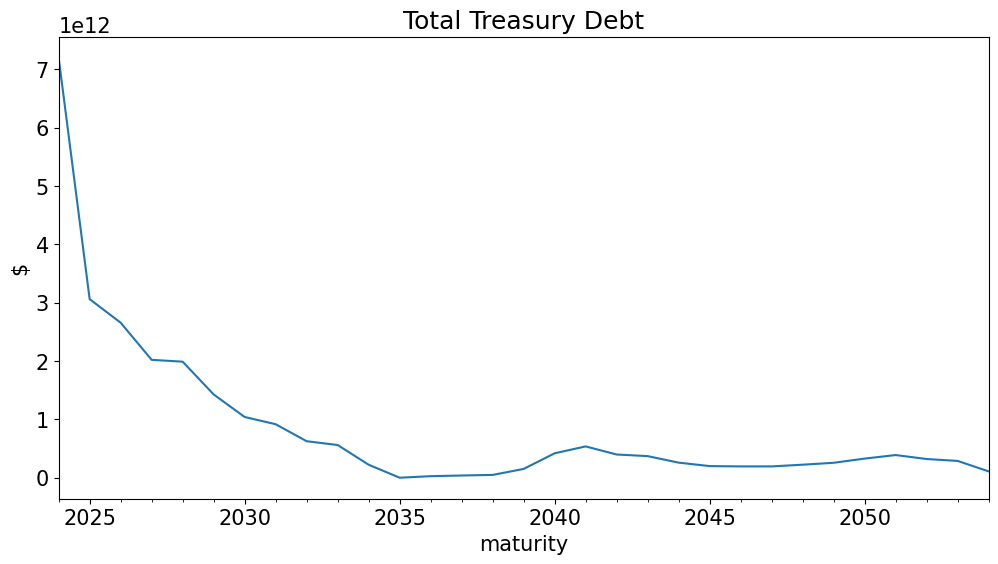

In [4]:
debts = data.pivot_table(values=KEY,index='maturity date',columns='type',aggfunc='sum') \
    .resample('Y').sum()
debts['TIPS'] = debts['TIPS bond'] + debts['TIPS note']
debts.drop(columns=['TIPS bond','TIPS note'],inplace=True)

debts.sum(axis=1).plot(title='Total Treasury Debt',ylabel='$',xlabel='maturity');

## 1.2.

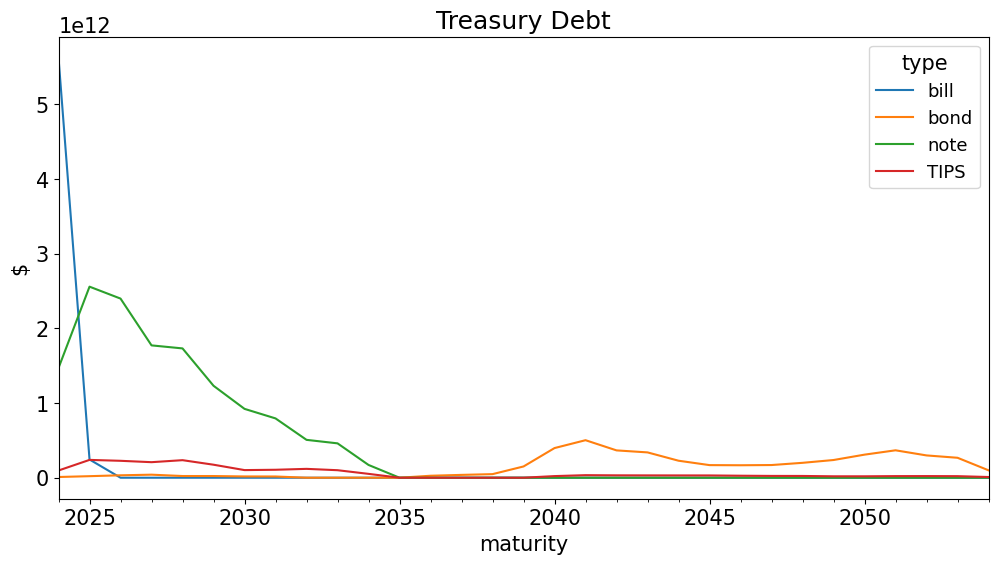

In [5]:
debts.plot(title='Treasury Debt',ylabel='$',xlabel='maturity');

### 1.3.

In [6]:
debts.sum().to_frame().rename(columns={0:'debt outstanding ($)'}).style.format('{:,.0f}')

,debt outstanding ($)
type,
bill,"5,866,778,000,000"
bond,"4,560,331,000,000"
note,"14,013,743,000,000"
TIPS,"2,025,754,000,000"


### 1.4.

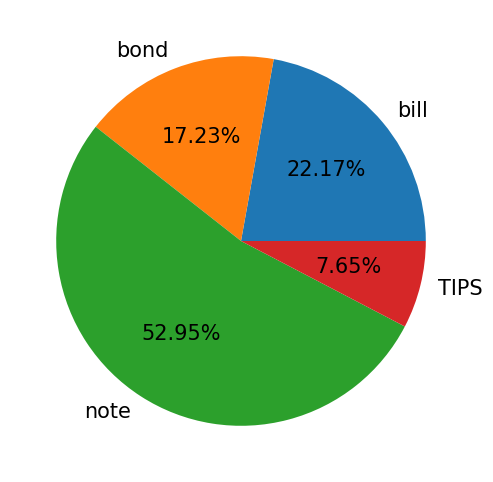

In [7]:
plt.pie(debts.sum().values, labels=debts.columns, autopct='%1.2f%%')
plt.show()

#### Not requested, but perhaps interesting to see outstanding via issue

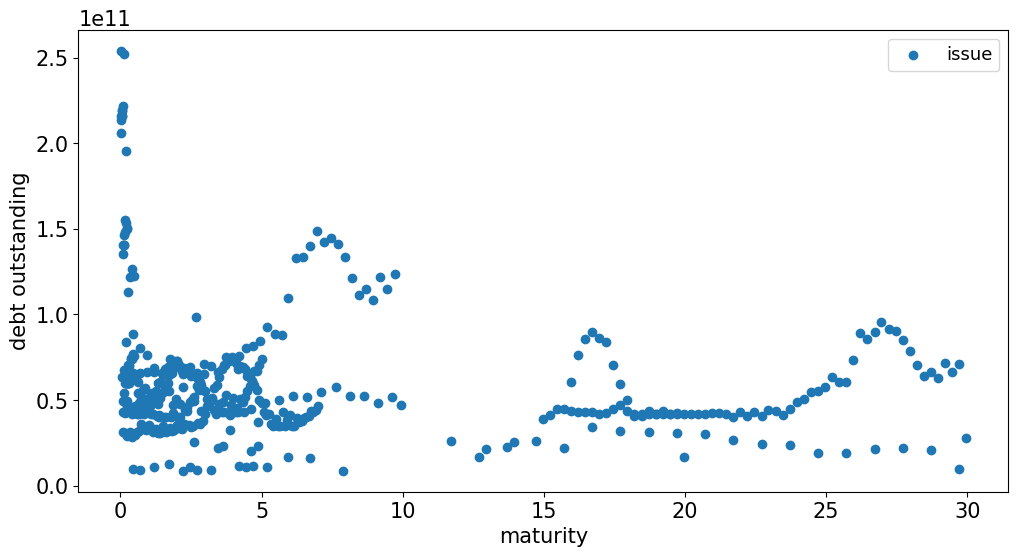

In [8]:
plt.scatter(data['ttm'],data[KEY]);
plt.legend(['issue']);
plt.ylabel('debt outstanding')
plt.xlabel('maturity');

### 1.5.

In [9]:
data['ttm'].describe().to_frame().T.style.format('{:.2f}')

,count,mean,std,min,25%,50%,75%,max
ttm,446.00,6.82,8.25,0.01,1.08,3.23,7.94,29.95


***

# 2 YTM and Price

The problems in this section ask you to calculate the **yield-to-maturity (YTM)** of various bonds.

You will need to use a nonlinear solver to solve for the YTM.

For any given bond, YTM ($y$) solves...

$$p = \sum_{i=1}^{2n}\frac{Fc/2}{(1+y/2)^i} + \frac{F}{(1+y/2)^{2n}}$$

where
* $p$ is the bond's price.
* $n$ is the number of years to maturity
* $c$ is the coupon rate (a percentage)
* $F$ is the face value. Use $F=100$

#### Solving for YTM
Consider using `fsolve` to solve the yield implicitly from the nonlinear equation. This function is imported with...

`from scipy.optimize import fsolve`

## 2.1

Consider a semiannual bond with the following stylized parameters:
* time-to-maturity of 30 years
* coupon rate: 3%
* Face value of 100

1. Assume the YTM is 5%. Calculate the price.
1. Assume the price is 87. Calculate the YTM.

## 2.2

### Data
Use the data in the `selected quotes` tab.
* It gives treasury bond data for various maturities, spaced roughly six months apart.
* Feel free to approximate the time-to-maturity to be exactly semiannually if that is easier for the problem below.
* Use the `price` column for the price data in the YTM formula. (No need to worry about "dirty" price, bid, ask, nor accrued interest.)

1. Calculate the yield-to-maturity for each issue. How close are your calculations to the provided column `ytm`?

1. Plot the time-to-maturity (TTM) against the calculated YTM.

***

# <span style="color:red">Solution 2</span>

In [10]:
from bondcalcs import price_bond, ytm

In [11]:
select = pd.read_excel(filepath_rawdata,sheet_name='selected quotes')

yieldcurve = pd.DataFrame(index=select.index,columns=['ttm','ytm provided','ytm calculated'],dtype=float)

for i in select.index:
    yieldcurve.loc[i,'ytm calculated'] = ytm(select.loc[i,'price'],select.loc[i,'ttm'],select.loc[i,'cpn rate']/100,x0=.02)

yieldcurve['ttm'] = select['ttm']
yieldcurve['ytm provided'] = select['ytm']

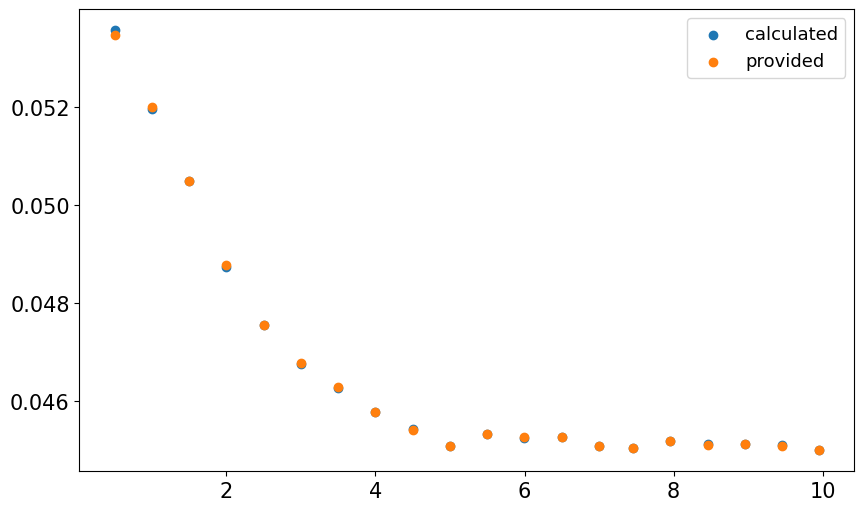

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(yieldcurve[['ttm']],yieldcurve[['ytm calculated']],label='calculated')
plt.scatter(yieldcurve[['ttm']],yieldcurve[['ytm provided']],label='provided')
plt.legend()
plt.show()

In [13]:
yieldcurve.style.format('{:.3f}')

,ttm,ytm provided,ytm calculated
0,0.501,0.053,0.054
1,0.999,0.052,0.052
2,1.500,0.050,0.051
3,1.999,0.049,0.049
4,2.500,0.048,0.048
5,2.998,0.047,0.047
6,3.499,0.046,0.046
7,4.000,0.046,0.046
8,4.501,0.045,0.045
9,4.999,0.045,0.045


***

# 3. Extra

Try these problems if you are inclined. They are not required.

### Data
Use the data in the `selected quotes` tab.

Focus on the nominal securities. 
* Exclude any row with `type` of `TIPS note` or `TIPS bond`.

## 3.1
Plot the time-to-maturity against the provided YTM.

## 3.2

1. Calculate the YTM of each (nominal) bond issue in the data set. 

1. Report how far your YTM calculation is from those reported in the data set.

1. Report your calculated YTM for the issues where the dataset does not provide a YTM.


## 3.3

For the Treasury bills, calculate the **discount yields**.

Identify the T-bills using `type`=`bill` or looking for `cpnrate` of 0.

***

# <span style="color:red">Solution 3</span>

### <span style="color:red">3.1.</span>

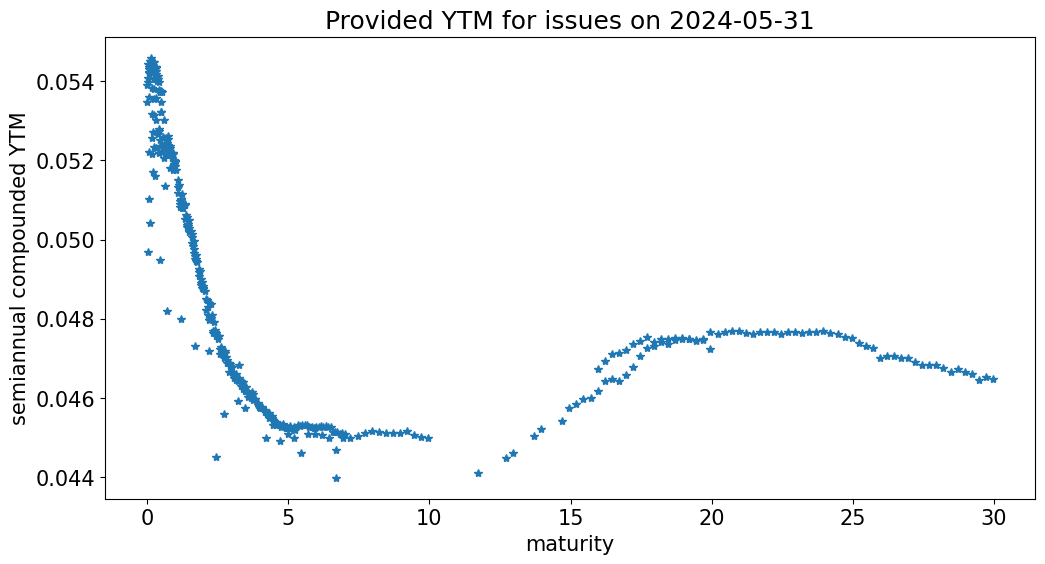

In [14]:
plt.plot(data['ttm'],data['ytm'],linestyle='',marker='*')
plt.title(f'Provided YTM for issues on {pd.to_datetime(QUOTE_DATE):%Y-%m-%d}')
plt.ylabel('semiannual compounded YTM')
plt.xlabel('maturity')
plt.show()

### <span style="color:red">3.2.</span>

In [15]:
DIRTY_YTM = False

if DIRTY_YTM:
    colkey = 'dirty price'
else:
    colkey = 'price'

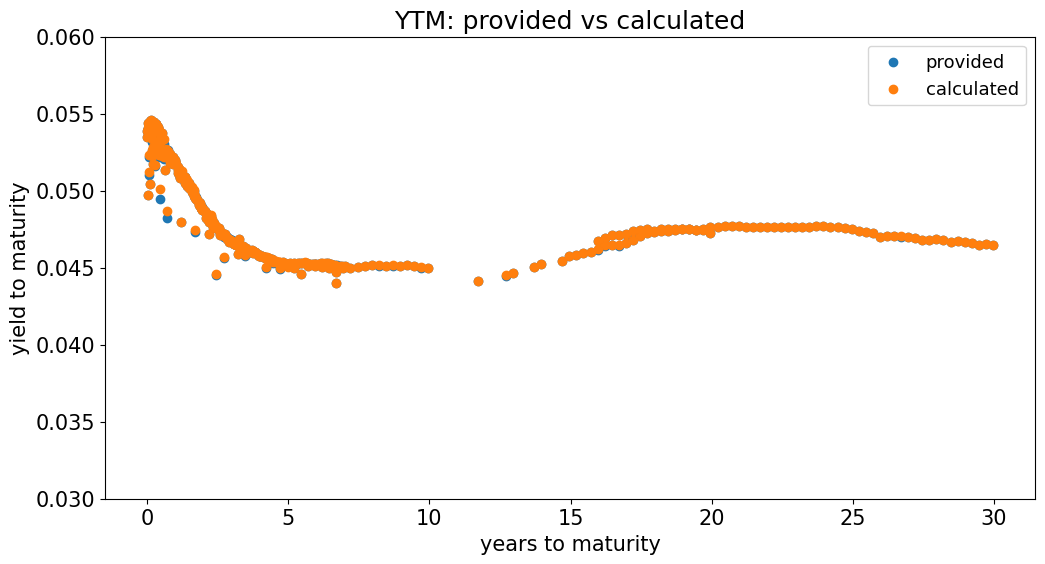

In [16]:
calcs = pd.DataFrame(index=data.index,columns=['ytm calculated'])
for i in calcs.index:        
    calcs.loc[i,'ytm calculated'] = ytm(data.loc[i,colkey], data.loc[i,'ttm'], data.loc[i,'cpn rate']/100)

calcs['ytm calculated'] = calcs['ytm calculated'].astype(float)

idx = data['ytm'].isna()
calcs.loc[idx,'ytm calculated'] = np.nan

plt.figure
plt.scatter(data['ttm'],data['ytm'], label='provided')
plt.scatter(data['ttm'],calcs['ytm calculated'],label='calculated')
plt.ylabel('yield to maturity')
plt.xlabel('years to maturity')
plt.ylim([0.03,.06])
plt.title('YTM: provided vs calculated')
plt.legend()
plt.show()

#### Difference between provided and calculated YTM

In [17]:
(calcs['ytm calculated'] - data['ytm']).astype(float).describe().to_frame().rename(columns={0:'summary'}).style.format('{:.6f}')

,summary
count,393.000000
mean,0.000023
std,0.000069
min,-0.000053
25%,-0.000000
50%,0.000003
75%,0.000015
max,0.000641


### <span style="color:red">3.3.</span>

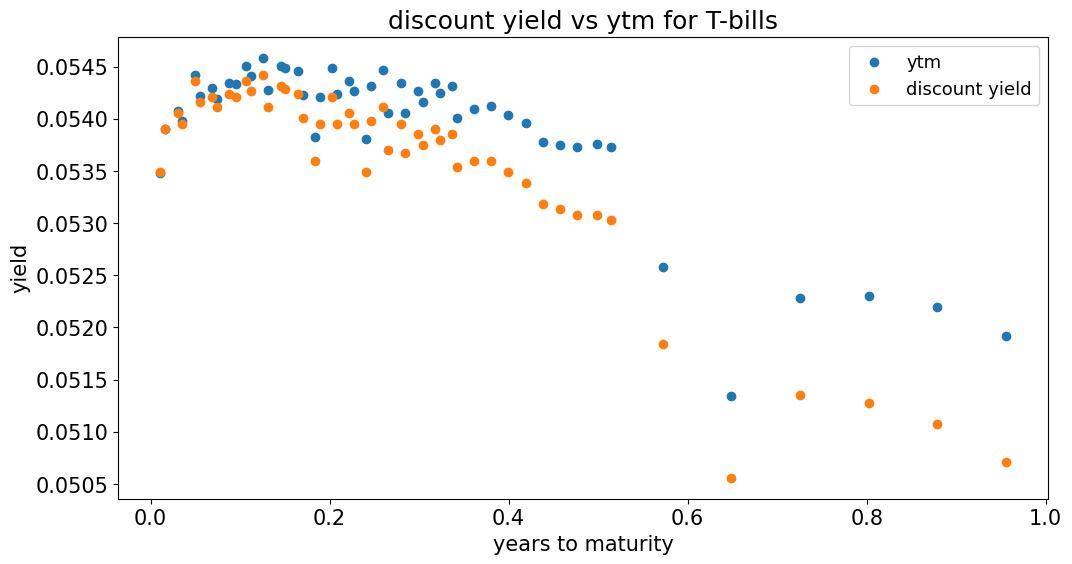

In [18]:
DAYCT_ADJ = 360/365

tbills = data[data['type']=='bill']
idx = tbills.index

calcs['discount yield'] = ((100-tbills['price'])/100 / (tbills['ttm'] * DAYCT_ADJ)).to_frame().rename(columns={0:'discount yield'})

plt.figure()
plt.scatter(data.loc[idx,'ttm'],calcs.loc[idx,'ytm calculated'],label= 'ytm')
plt.scatter(data.loc[idx,'ttm'],calcs.loc[idx,'discount yield'],label='discount yield')
plt.legend()
plt.ylabel('yield')
plt.xlabel('years to maturity')
plt.title('discount yield vs ytm for T-bills')
plt.show()

In [19]:
calcs.dropna(axis=0,how='any').style.format('{:.3%}')

,ytm calculated,discount yield
0,5.348%,5.349%
1,5.390%,5.390%
2,5.408%,5.406%
3,5.398%,5.395%
5,5.442%,5.437%
6,5.422%,5.416%
7,5.429%,5.421%
8,5.419%,5.411%
12,5.434%,5.424%
13,5.433%,5.421%
